In [1]:
import spikeinterface as si
import matplotlib.pyplot as plt
%matplotlib inline
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
global_job_kwargs = dict(n_jobs = 4)
si.set_global_job_kwargs(**global_job_kwargs)

In [3]:
def spike_inf_formation(filepath):
    sorting_curated_phy = se.read_phy(filepath + "/phy_folder_for_kilosort/")
    spike_inf = np.column_stack((np.array(range(0, len(np.load(filepath + "/phy_folder_for_kilosort/spike_clusters.npy").astype(str)))).astype(str),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_clusters.npy"),
                                   np.load(filepath + "/kilosort4/sorter_output/spike_positions.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_templates.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_times.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/amplitudes.npy")))
    spike_inf = pd.DataFrame(spike_inf)
    spike_inf.columns = ['name', 'cluster', 'position_1', 'position_2', 'template','time', 'amplitude']

    cluster_group = pd.read_csv(filepath + "phy_folder_for_kilosort/cluster_group.tsv", sep = "\t")
    cluster_group = cluster_group[cluster_group['group'] == "good"]

    spike_inf['cluster'] = spike_inf['cluster'].astype('int64')
    spike_inf = spike_inf[spike_inf['cluster'].isin(cluster_group['cluster_id'].values)]    

    sorting_curated_phy = se.read_phy(filepath + "/phy_folder_for_kilosort/", exclude_cluster_groups=['noise'])

    df_1 = pd.DataFrame(list(sorting_curated_phy.count_num_spikes_per_unit().items()), columns=["cluster", 'value'])
    df_1['value'] = df_1['value'].astype(int)
    df_1 = df_1.sort_values(by='value', ascending=False)

    df_2 = pd.DataFrame(np.unique(spike_inf['cluster'], return_counts=True)).T
    df_2.columns = ['cluster', 'value']
    df_2['value'] = df_2['value'].astype(int)
    df_2 = df_2.sort_values(by = 'value', ascending=False)

    spike_inf['cluster'] = spike_inf['cluster'].map(dict(zip(df_2['cluster'], df_1['cluster'])))

    return sorting_curated_phy, spike_inf

In [5]:
def get_channel_id(data):
    x_embedding = data['position_1']
    y_embedding = data['position_2']
    if y_embedding <= 25:
        if x_embedding <= 25:
            return '2'
        elif 25 < x_embedding <= 75:
            return '12'
        elif 75 < x_embedding < 625:
            return '11'
        else:
            return '1'
    elif 25 < y_embedding <= 75:
        if x_embedding <= 25:
            return '4'
        elif 25 < x_embedding <= 75:
            return '10'
        elif 75 < x_embedding < 625:
            return '9'
        else:
            return '3'
    elif 75 < y_embedding <= 125:
        if x_embedding <= 25:
            return '6'
        elif 25 < x_embedding <= 75:
            return '8'
        elif 75 < x_embedding < 625:
            return '7'
        else:
            return '5'
    elif 125 < y_embedding <= 225:
        if 125 < x_embedding <= 175:
            return '14'
        elif 175 < x_embedding <= 225:
            return '24'
        elif 225 < x_embedding < 475:
            return '23'
        else:
            return '13'
    elif 225 < y_embedding <= 275:
        if 125 < x_embedding <= 175:
            return '16'
        elif 175 < x_embedding <= 225:
            return '22'
        elif 225 < x_embedding < 475:
            return '21'
        else:
            return '15'
    elif 275 < y_embedding <= 325:
        if 125 < x_embedding <= 175:
            return '18'
        elif 175 < x_embedding <= 225:
            return '20'
        elif 225 < x_embedding < 475:
            return '19'
        else:
            return '17'
    elif 325 < y_embedding <= 425:
        if 275 < x_embedding <= 325:
            return '26'
        else:
            return '25'
    elif 425 < y_embedding <= 475:
        if 275 < x_embedding <= 325:
            return '28'
        else:
            return '27'
    else:
        if 275 < x_embedding <= 325:
            return '30'
        else:
            return '29'

In [6]:
def get_cluster_position(spike_inf):
    cluster_group = np.unique(spike_inf['cluster'])

    cluster_position = pd.DataFrame(columns=['position_1', 'position_2', 'number'])

    for i in cluster_group:
        temp = spike_inf[spike_inf['cluster'] == i]
        temp['position_1'] = temp['position_1'].astype(float)
        temp['position_2'] = temp['position_2'].astype(float)
        cluster_position.loc[i] = [np.mean(temp['position_1']), np.mean(temp['position_2']),
                                len(temp)]
    cluster_position['channel_id'] = cluster_position.apply(get_channel_id, axis=1)
    cluster_position['cluster'] = cluster_position.index.astype(str)
    return cluster_position

def plot_cluster_group(cluster_position, size = 15, title = None, save_path = None):
    from adjustText import adjust_text
    plt.figure(figsize=(size,size))

    sns.scatterplot(x = cluster_position['position_1'],
                    y = cluster_position['position_2'],
                    hue=cluster_position.index.astype(str),
                    legend=None)
    
    texts = []
    for i in range(len(cluster_position)):
        text = plt.text(list(cluster_position["position_1"])[i], list(cluster_position["position_2"])[i], list(cluster_position["cluster"])[i], fontsize=15, ha="center", va="bottom")
        texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))
    
    plt.title(title, loc="left")
    plt.savefig(save_path)
    plt.close()

def spike_waveform(spike_inf, file_path):
    templates = np.load(file=file_path)
    templates = np.mean(templates, axis=2, keepdims=False)
    templates = pd.DataFrame(templates)
    templates = pd.DataFrame({
        'row_index': templates.index,
        'row_value': templates.values.tolist()}
    )
    templates['row_index'] = templates['row_index'].astype(str)
    templates = templates.set_index('row_index')['row_value'].to_dict()

    spike_inf['template'] = spike_inf['template'].astype(str)
    spike_inf['waveform'] = spike_inf['template'].map(templates)
    return spike_inf

def get_waveform_segemantation(spike_inf, start_time, end_time):
    spike_inf['time'] = spike_inf['time'].astype(int)
    spike_range = spike_inf[spike_inf['time'] > int(start_time * 10000)]
    spike_range = spike_range[spike_range['time'] <= int(end_time * 10000)]

    spike_range['start'] = (spike_range['time'] - 15 - start_time*10000).astype(int)-1
    spike_range['end'] = (spike_range['time'] + 14 - start_time*10000).astype(int) - 1

    spike_dataframe = pd.DataFrame(np.zeros((len(np.unique(spike_inf['cluster'])), 10000)),
                               index= np.unique(spike_inf['cluster']))
    
    spike_dataframe.columns = range(int(start_time * 10000), int(end_time * 10000))
    spike_dataframe.columns = spike_dataframe.columns.astype(int)

    spike_dataframe.index = spike_dataframe.index.astype(str)
    for index, row in spike_range.iterrows():
        cluster = str(row['cluster'])  
        time = row['time'] 
        waveform = row['waveform']
        start_col = row['start']
        end_col = row['end']

        spike_dataframe.iloc[spike_dataframe.index.get_loc(cluster), start_col:end_col+1] = waveform[:end_col-start_col + 1]
    
    return spike_dataframe

In [7]:
def get_recording(file_path):
    recording_raw = se.read_blackrock(file_path=file_path).remove_channels(['31', '32'])
    recording_raw = recording_raw.set_probegroup(probe_30channel)
    recording_raw = spre.bandpass_filter(recording_raw, freq_min=300, freq_max=3000)
    recording_raw = spre.common_reference(recording_raw, reference="global", operator="median")
    return recording_raw

In [8]:
recoding = {}
import os

recording_name = os.listdir("/media/ubuntu/sda/data/mouse6/ns4/natural_image/")
for key in recording_name:
    date = key.split("_")[1]
    recoding[date] = get_recording(file_path=f'/media/ubuntu/sda/data/mouse6/ns4/natural_image/{key}')

In [9]:
sorting_curated_phy_dict = {}
spike_inf_dict = {}

file_name = os.listdir("/media/ubuntu/sda/data/mouse6/output/filtered/")
for key in file_name:
    date = key.split("_")[1]
    sorting_curated_phy_dict[date], spike_inf_dict[date] = spike_inf_formation(filepath=f'/media/ubuntu/sda/data/mouse6/output/filtered/{key}/')

In [14]:
file_name = os.listdir("/media/ubuntu/sda/data/mouse6/output/filtered/")

for key in spike_inf_dict.keys():
    matching_file = None
    for file in file_name:
        if key in file:
            matching_file = file
            break
    file_path = f'/media/ubuntu/sda/data/mouse6/output/filtered/{matching_file}/phy_folder_for_kilosort/templates.npy'
    spike_inf_dict[key] = spike_waveform(spike_inf=spike_inf_dict[key], file_path=file_path)

In [15]:
cluster_position_dict = {}

for key in spike_inf_dict.keys():
    cluster_position_dict[key] = get_cluster_position(spike_inf=spike_inf_dict[key])

In [16]:
for key in cluster_position_dict.keys():
    plot_cluster_group(cluster_position=cluster_position_dict[key],
                       size=10,
                       title=key,
                       save_path=f'/media/ubuntu/sda/data/mouse6/output/single_neuron/cluster_position/{key}.png')

In [17]:
cluster_position_all = pd.DataFrame()
for key in cluster_position_dict.keys():
    cluster_position_dict[key]['date'] = key
    cluster_position_all = pd.concat((cluster_position_all, cluster_position_dict[key]), axis=0)

In [18]:
cluster_position_all['cluster_date'] = cluster_position_all['cluster'] + '_' + cluster_position_all['date']

In [19]:
threshold = np.arange(1, 10.5, 0.5)
num_neuron = []
for num in threshold:
    cluster_position_all['Neuron'] = None
    cluster_position_all.iloc[0, 7] = 1
    neuron_inf = pd.DataFrame(cluster_position_all.iloc[0, :]).T
    neuron = 1
    for i in range(1, len(cluster_position_all)):
        found = False
        for j in range(len(neuron_inf)):
            if (abs(cluster_position_all.iloc[i, 0] - neuron_inf.iloc[j, 0]) <= num) and (abs(cluster_position_all.iloc[i, 1] - neuron_inf.iloc[j, 1]) <= num):
                cluster_position_all.iloc[i, 7] = neuron_inf.iloc[j, 7]
                found = True
                break
        if not found:
            neuron += 1
            cluster_position_all.iloc[i,7] = neuron
            neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_position_all.iloc[i, :]).T), axis=0)

    neurons_with_count_gt_16 = cluster_position_all['Neuron'].value_counts()
    neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()
    num_neuron.append(len(neuron_values))


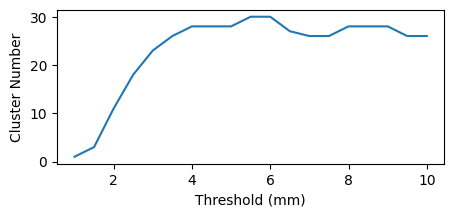

In [153]:
plt.figure(figsize=(5, 2))
sns.lineplot(x = threshold,
                y = num_neuron)
plt.xlabel("Threshold (mm)")
plt.ylabel("Cluster Number")
plt.show()

In [20]:
num = 6
cluster_position_all['Neuron'] = None
cluster_position_all.iloc[0, 7] = 1
neuron_inf = pd.DataFrame(cluster_position_all.iloc[0, :]).T
neuron = 1
for i in range(1, len(cluster_position_all)):
    found = False
    for j in range(len(neuron_inf)):
        if (abs(cluster_position_all.iloc[i, 0] - neuron_inf.iloc[j, 0]) <= num) and (abs(cluster_position_all.iloc[i, 1] - neuron_inf.iloc[j, 1]) <= num):
            cluster_position_all.iloc[i, 7] = neuron_inf.iloc[j, 7]
            found = True
            break
    if not found:
        neuron += 1
        cluster_position_all.iloc[i,7] = neuron
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_position_all.iloc[i, :]).T), axis=0)

neurons_with_count_gt_16 = cluster_position_all['Neuron'].value_counts()
neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()

In [21]:
cluster_position_all = cluster_position_all[cluster_position_all['Neuron'].isin(neuron_values)]

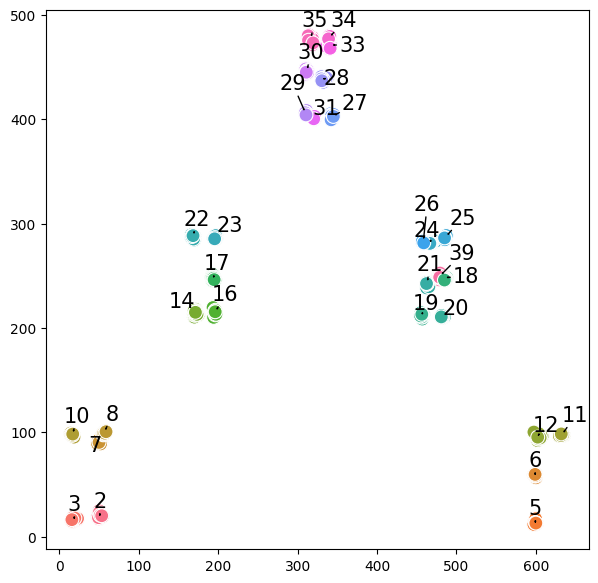

In [188]:
from adjustText import adjust_text
plt.figure(figsize=(7, 7))
cluster_position_all['Neuron'] = cluster_position_all['Neuron'].astype(str)
sns.scatterplot(x = cluster_position_all['position_1'],
                y = cluster_position_all['position_2'],
                hue=cluster_position_all['Neuron'],
                legend=None,
                s = 100)

cluster_position_mean = cluster_position_all.groupby('Neuron', as_index=False)[['position_1', 'position_2']].mean()
texts = []
for i in range(len(cluster_position_mean)):
    text = plt.text(list(cluster_position_mean["position_1"])[i], list(cluster_position_mean["position_2"])[i], list(cluster_position_mean["Neuron"])[i], fontsize=15, ha="center", va="bottom")
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))
plt.xlabel("")
plt.ylabel("")

plt.show()

In [22]:
for key in spike_inf_dict.keys():
    spike_inf_dict[key]['Neuron'] = None

for key in spike_inf_dict.keys():
    temp = cluster_position_all[cluster_position_all['date'] == key]
    spike_inf_dict[key] =  spike_inf_dict[key][spike_inf_dict[key]['cluster'].isin(list(temp['cluster'].astype(int)))]
    for index, row in temp.iterrows():
        spike_inf_dict[key].loc[spike_inf_dict[key]['cluster'] == int(row['cluster']), 'Neuron'] = row['Neuron']

In [23]:
trigger_time_dict = {}

for filename in os.listdir("/media/ubuntu/sda/data/mouse6/output/get_trigger/trigger_time"):
    if filename.endswith('.csv'):
        file_path = os.path.join("/media/ubuntu/sda/data/mouse6/output/get_trigger/trigger_time/", filename)
        df = pd.read_csv(file_path)
        
        key = filename[:6]
        
        trigger_time_dict[key] = df

In [124]:
def get_raster(spike_inf, start_time, end_time):
    num_units = len(np.unique(spike_inf['Neuron']))
    num_frames = 5000
    spike_matrix = np.zeros((num_units, num_frames), dtype=int)
    
    spike_inf['time'] = spike_inf['time'].astype(int)
    spike_inf['Neuron'] = spike_inf['Neuron'].astype(str)
    temp = spike_inf[(spike_inf['time'] >= start_time.values[0]) & (spike_inf['time'] < end_time.values[0])]
    temp['time'] = temp['time'] - start_time.values[0]

    for idx, cluster in enumerate(np.unique(spike_inf['Neuron'])):
        temp_1 = temp[temp['Neuron'] == cluster]
        for time in list(temp_1['time']):
            #start_idx = max(0, time - 5)
            #end_idx = min(5000, time + 6)
            #spike_matrix[idx, start_idx:end_idx] = 1
            spike_matrix[idx, time] = 1

    spike_matrix = pd.DataFrame(spike_matrix.T)
    spike_matrix.columns = np.unique(spike_inf['Neuron'])

    return spike_matrix


In [25]:
for key in trigger_time_dict.keys():
    trigger_time_dict[key]['start'] = trigger_time_dict[key]['start'] + 2500
    trigger_time_dict[key]['end'] = trigger_time_dict[key]['end'] - 2500

In [ ]:
spike_inf_dict['012123']

In [125]:
raster_dict = {}
key = '012123'
#for key in spike_inf_dict.keys():
raster_dict[key] = {}
for i in np.unique(trigger_time_dict[key]['image']):
    raster_dict[key][f'Image_{i}'] = {}
    trigger_time_temp = trigger_time_dict[key][trigger_time_dict[key]['image'] == i]
    for j in np.unique(trigger_time_temp['order']):
        raster_dict[key][f'Image_{i}'][j] = get_raster(spike_inf_dict[key], start_time=trigger_time_temp[trigger_time_temp['order'] == j].iloc[:, 1], end_time=trigger_time_temp[trigger_time_temp['order'] == j].iloc[:, 2])

In [129]:
image_dict = {}
for key in raster_dict['012123'].keys():
    image_dict[key] = {}
    value = raster_dict['012123']['Image_1']['1_1'].columns
    for i in range(28):
        image_dict[key][f'Neuron_{value[i]}'] = pd.DataFrame()
        for _, item in raster_dict['012123'][key].items():
            temp = item.iloc[:, i]
            image_dict[key][f'Neuron_{value[i]}'] = pd.concat((image_dict[key][f'Neuron_{value[i]}'], item.iloc[:, i]), axis=1)


In [ ]:
def plot_firing_rate(image_dict, image):
    fig, axes = plt.subplots(4, 7, figsize=(40, 16))  
    axes = axes.flatten()  

    for idx, neuron in enumerate(image_dict[image].keys()):
        df = image_dict[image][neuron]  
        result_df = pd.DataFrame()
        
        for i in range(100):
            start_idx = i * 50
            end_idx = (i + 1) * 50
            chunk_sum = df.iloc[start_idx:end_idx].sum().to_frame().T
            result_df = pd.concat([result_df, chunk_sum], ignore_index=True)

        
        
        means = np.mean(result_df, axis=1)
        stds = np.std(result_df, axis=1)
        
        x = np.arange(1, 101)
        
        ax = axes[idx]
        
        ax.plot(x[x < 50], means[x < 50], '-o', color='#1E90FF', label='Mean (x < 50)', ms = 3)
        ax.plot(x[x >= 50], means[x >= 50], '-o', color='orange', label='Mean (x >= 50)', ms = 3)
        
        ax.fill_between(x, means - stds, means + stds, where=(x < 50), color='#1E90FF', alpha=0.3)
        ax.fill_between(x, means - stds, means + stds, where=(x >= 50), color='orange', alpha=0.3)
        
        ax.axvline(x=49.5, color='black', linestyle='--', label='Trigger')
        
        ax.set_title(f'{neuron}')

    plt.tight_layout()


In [435]:
for key in image_dict.keys():
    plot_firing_rate(image_dict, key)
    plt.savefig(f"/media/ubuntu/sda/data/mouse6/output/single_neuron/firing_rate/{key}.png")
    plt.close()

In [438]:
def plot_firing_rate(image_dict, Neuron):
    fig, axes = plt.subplots(9, 13, figsize=(100, 32))  
    axes = axes.flatten()  

    num = 0
    for image in image_dict.keys():
        df = image_dict[image][Neuron]  
        result_df = pd.DataFrame()
        
        for i in range(100):
            start_idx = i * 50
            end_idx = (i + 1) * 50
            chunk_sum = df.iloc[start_idx:end_idx].sum().to_frame().T
            result_df = pd.concat([result_df, chunk_sum], ignore_index=True)

        
        
        means = np.mean(result_df, axis=1)
        stds = np.std(result_df, axis=1)
        
        x = np.arange(1, 101)
        
        ax = axes[num]
        
        ax.plot(x[x < 50], means[x < 50], '-o', color='#1E90FF', label='Mean (x < 50)', ms = 3)
        ax.plot(x[x >= 50], means[x >= 50], '-o', color='orange', label='Mean (x >= 50)', ms = 3)
        
        ax.fill_between(x, means - stds, means + stds, where=(x < 50), color='#1E90FF', alpha=0.3)
        ax.fill_between(x, means - stds, means + stds, where=(x >= 50), color='orange', alpha=0.3)
        
        ax.axvline(x=49.5, color='black', linestyle='--', label='Trigger')
        
        ax.set_title(f'{image}')
        num += 1
    plt.tight_layout()

In [439]:
for key in image_dict['Image_1'].keys():
    plot_firing_rate(image_dict, key)
    plt.savefig(f"/media/ubuntu/sda/data/mouse6/output/single_neuron/firing_rate_neuron/{key}.png")
    plt.close()

In [443]:
def collect_df(image_dict, Neuron):
    collected_df = pd.DataFrame()
    for image in image_dict.keys():
        df = image_dict[image][Neuron]  
        result_df = pd.DataFrame()
        
        for i in range(100):
            start_idx = i * 50
            end_idx = (i + 1) * 50
            chunk_sum = df.iloc[start_idx:end_idx].sum().to_frame().T
            result_df = pd.concat([result_df, chunk_sum], ignore_index=True)
        
        means = np.mean(result_df, axis=1)
        collected_df = pd.concat((collected_df, means), axis=1)
    return collected_df
        

In [127]:
for date in raster_dict.keys():
    for image in raster_dict[date].keys():
        for image_order, df in raster_dict[date][image].items():
            result_df = pd.DataFrame()
            for i in range(100):
                start_idx = i * 50
                end_idx = (i + 1) * 50
                chunk_sum = df.iloc[start_idx:end_idx].sum().to_frame().T
                result_df = pd.concat([result_df, chunk_sum], ignore_index=True)
            raster_dict[date][image][image_order] = result_df

In [86]:
raster_flatten = {}
for date in raster_dict.keys():
    raster_flatten[date] = {}
    for image in raster_dict[date].keys():
        raster_flatten[date][image] = {}
        for image_order, df in raster_dict[date][image].items():
            df = df.to_numpy().flatten()
            raster_flatten[date][image][image_order] = df

In [107]:
def plot_pearson(df):
    from scipy.stats import pearsonr
    pearson_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(i, 10):  
            corr, _ = pearsonr(df.iloc[:, i], df.iloc[:, j])
            if corr > 0.8:
                corr = 0.6
            pearson_matrix[i, j] = corr
            pearson_matrix[j, i] = corr

    plt.figure(figsize=(6, 5))  
    sns.heatmap(pearson_matrix,cmap='coolwarm', center=0, annot=True, linewidths=0.5)
    plt.show()

In [131]:
a = image_dict['Image_1']['Neuron_18']
b = image_dict['Image_1']['Neuron_21']
c = image_dict['Image_1']['Neuron_24']

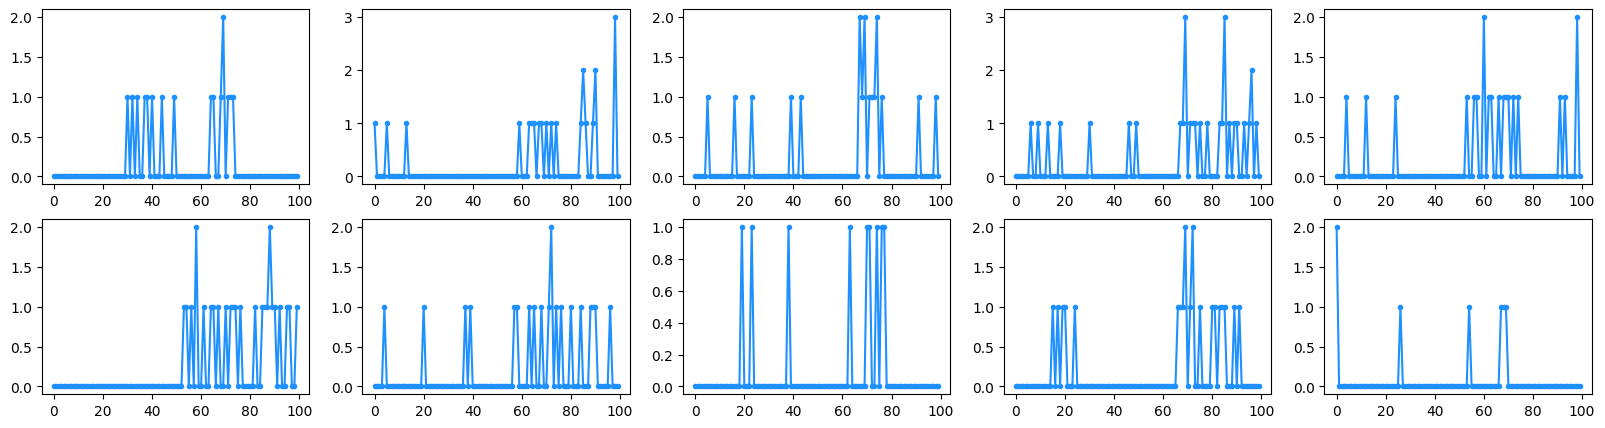

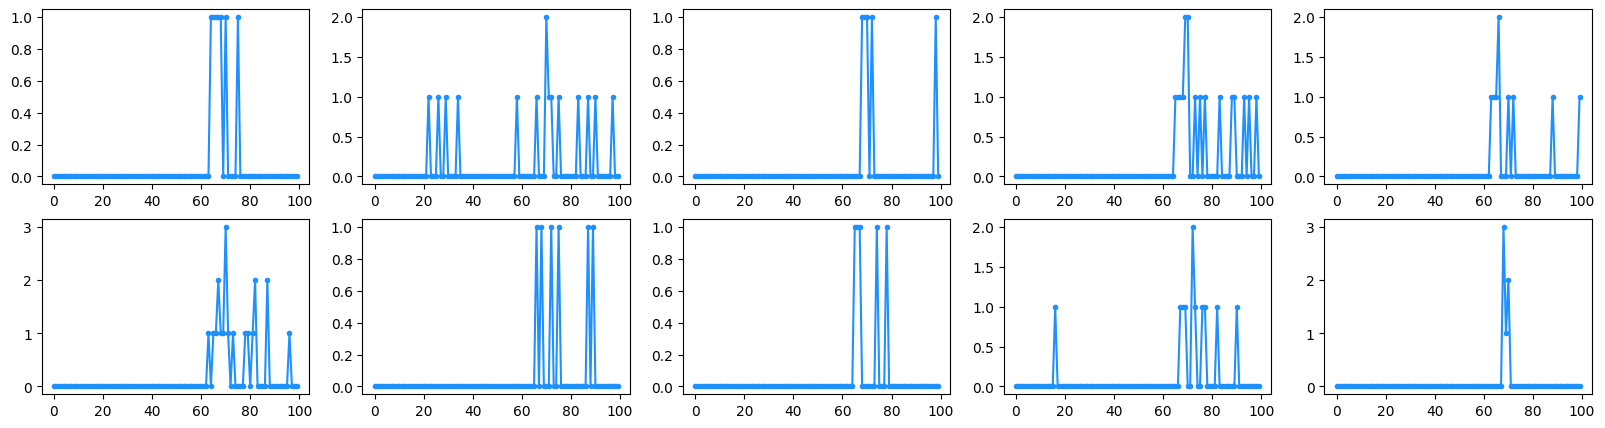

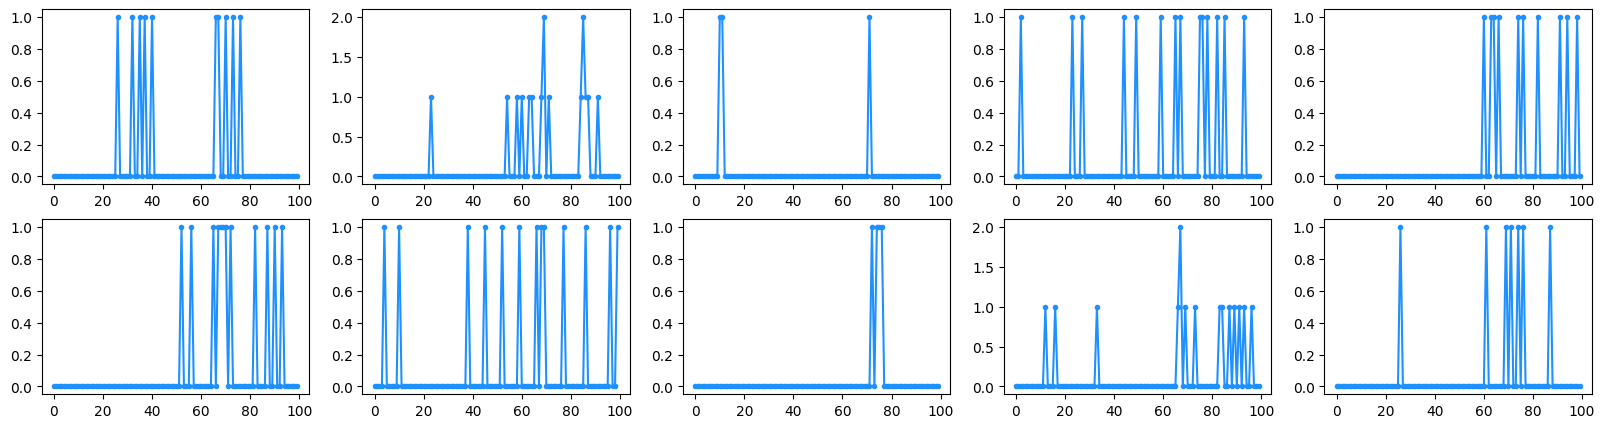

In [132]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))  
axes = axes.flatten()  

for i in range(10):
    ax = axes[i]
        
    ax.plot(range(100), a.iloc[:, i], '-o', color='#1E90FF', label='Mean (x < 50)', ms = 3)
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(20, 5))  
axes = axes.flatten()  

for i in range(10):
    ax = axes[i]
        
    ax.plot(range(100), b.iloc[:, i], '-o', color='#1E90FF', label='Mean (x < 50)', ms = 3)
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(20, 5))  
axes = axes.flatten()  

for i in range(10):
    ax = axes[i]
        
    ax.plot(range(100), c.iloc[:, i], '-o', color='#1E90FF', label='Mean (x < 50)', ms = 3)
plt.show()

In [136]:
a = pd.concat((spike_inf_dict['012123']['Neuron'], spike_inf_dict['012123']['waveform']), axis=1)

In [142]:
def get_spike_waveforms(spikes, results_dir, bfile=None, chan=None):
    """Get waveform for each spike in `spikes`, multi- or single-channel.
    
    Parameters
    ----------
    spikes : list or array-like
        Spike times (in units of samples) for the desired waveforms, from
        `spike_times.npy`.
    results_dir : str or Path
        Path to directory where Kilosort4 sorting results were saved.
    bfile : kilosort.io.BinaryFiltered; optional
        Kilosort4 data file object. By default, this will be loaded using the
        information in `ops.npy` in the saved results.
    chan : int; optional.
        Channel to use for single-channel waveforms. If not specified, all
        channels will be returned.

    Returns
    -------
    waves : np.ndarray
        Array of spike waveforms with shape `(nt, len(spikes))`.
    
    """
    if isinstance(spikes, int):
        spikes = [spikes]

    if bfile is None:
        ops = io.load_ops(results_dir + '/ops.npy')
        bfile = io.bfile_from_ops(ops)
    whitening_mat_inv = np.load(results_dir + '/whitening_mat_inv.npy')

    waves = []
    for t in spikes:
        tmin = t - bfile.nt0min
        tmax = t + (bfile.nt - bfile.nt0min)
        w = bfile[tmin:tmax].cpu().numpy()
        if whitening_mat_inv is not None:
            w = whitening_mat_inv @ w
        if w.shape[1] == bfile.nt:
            # Don't include spikes at the start or end of the recording that
            # get truncated to fewer time points.
            waves.append(w)
    waves = np.stack(waves, axis=-1)

    if chan is not None:
        waves = waves[chan,:]
    
    bfile.close()

    return waves

In [140]:
from kilosort import io

In [145]:
spike_inf_dict['021322']['time'] = spike_inf_dict['021322']['time'].astype(int)

In [146]:
a = get_spike_waveforms(spikes=list(spike_inf_dict['021322']['time']), results_dir="/media/ubuntu/sda/data/mouse6/output/filtered/mouse6_021322_natural_image001/kilosort4/sorter_output")

In [153]:
b = a[:, :, 1]